In [1]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import pandas as pd
import galois

# import sys
# sys.path.append("../../../../ldpc/src/")
# from ldpc import bp_decoder
# from ldpc.osd import bposd_decoder

from scipy.optimize import curve_fit
from result import Result, save_new_res, res_to_line

In [19]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [9,6,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[0]
# code = [18,12,1,11,3,2,15,1]
# code = [28,14,26,6,8,7,9,20]
code = [4,4,3,1,2,3,1,2]

In [20]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [21]:
bit_nbhd = [np.where(Hx[:,i])[0] for i in range(Hx.shape[1])]
check_nbhd = [np.where(Hx[i])[0] for i in range(Hx.shape[0])]

In [22]:
# error = np.zeros(Hx.shape[1])
error = np.array([0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# syndrome = (Hx @ error) % 2

mask = np.zeros(Hx.shape[0])

# mask[2] = 1
# error[0] = 1
p = 0.005

synd = (Hx @ error) % 2
print(synd)

[0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1]


In [ ]:
def bp(H, synd, p, T):
    b2c_messages_t0 = np.copy(H) * np.log((1-p)/p)
    b2c_messages_t1 = np.copy(b2c_messages_t0)

    c2b_messages_t0 = np.zeros(H.shape)
    c2b_messages_t1 = np.copy(c2b_messages_t0)

    def update_bit_to_check(bit, check):
        m = np.log((1-p)/p) + np.sum([c2b_messages_t0[nbr][bit] for nbr in bit_nbhd[bit] if nbr != check])
        b2c_messages_t1[check][bit] = m

    def update_check_to_bit(bit, check):
        m = (1-mask[check])*(-1)**synd[check] * 2 * np.arctanh(np.prod([np.tanh(b2c_messages_t0[check][nbr]/2) for nbr in check_nbhd[check] if nbr != bit]))
        c2b_messages_t1[check][bit] = m


    for i in range(T):
        for check, nbhd in enumerate(check_nbhd):
            for bit in nbhd:
                update_check_to_bit(bit, check)
            for bit, nbhd in enumerate(bit_nbhd):
                for check in nbhd:
                    update_bit_to_check(bit, check)

        b2c_messages_t0 = b2c_messages_t1
        c2b_messages_t0 = c2b_messages_t1


    return [np.log((1-p)/p) + np.sum([c2b_messages_t1[check][bit] for check in bit_nbhd[bit]]) for bit in range(H.shape[0])]
bp(Hx, synd, p, Hx.shape[1])


In [127]:
prob_log_ratios = np.array([0. ,  0. ,  0. ,  0. ,  5.29, 0.,   0.,   0.  , 0. ,  5.29, 5.29, 0. ,  5.29, 0.,
 5.29, 5.29, 0.,   5.29, 0.,   5.29, 0.,   0.,   5.29, 0.,   0. ,  0. ,  5.29, 5.29,
 0. ,  0. ,  0.  , 5.29])
np.argsort(prob_log_ratios)

array([ 0, 23, 18, 24, 16, 30, 25, 13, 11, 20, 21,  8,  7,  6,  5, 29,  3,
        2,  1, 28, 26, 27, 15, 19, 17, 14, 12, 10,  9,  4, 22, 31],
      dtype=int64)

In [197]:
lin_ind_cols = np.array([ 0, 23, 18, 24, 16, 30, 25, 13, 11, 20, 21,  8,  7,  6,  5, 29,  
                         3, 2,  1, 28, 26, 27, 15, 19, 17, 14, 12, 10,  9,  4, 22, 31])
lin_ind_cols_inds = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,20])

In [198]:
error = np.zeros(Hx.shape[1]).astype(np.uint8)
error[0] = 1
error[1] = 1
mask = np.zeros(Hx.shape[0]).astype(np.uint8)
mask[0] = 1
mask[2] = 1
syndrome = (Hx @ error) % 2
print(mask)
print(syndrome)
print(syndrome[mask==0])

[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0]


In [203]:
syndrome2 = np.array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
syndrome3 = np.array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [205]:
Hop = Hx[:, np.argsort(prob_log_ratios)]
print(Hop.shape)
GF = galois.GF(2)
rank = matrix_rank(GF(Hop))
Hs = Hop[:, lin_ind_cols_inds]
print(Hs.shape)

print(matrix_rank(GF(Hs)))

es = np.copy(np.linalg.inv(GF(Hs)) @ GF(syndrome3))
# es = np.hstack([es, np.zeros(Hx.shape[1]-rank)])

es

(16, 32)
(16, 16)
16


array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1], dtype=uint8)

In [118]:
matrix_rank(GF(Hs))

16

In [13]:
10**(5)

100000

In [10]:
np.linspace(1e-3, 1e-2, 5)

array([0.001  , 0.00325, 0.0055 , 0.00775, 0.01   ])

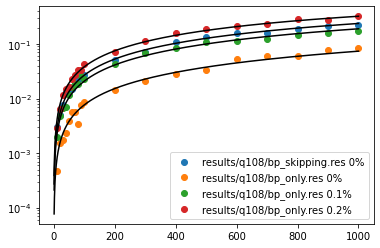

In [2]:
files = ["results/q108/bp_skipping.res", "results/q108/bp_only.res", "results/q108/bp_only.res", "results/q108/bp_only.res"]
masks = [0, 0, 0.1, 0.2]

for i, f in enumerate(files):

    df = pd.read_csv(f)
    df['p_error'] = 1 - df['p_log']
    df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])

    tmp_df = df[df["p_mask"] == masks[i]]

    def fun(x, a):
        return 1 - (1 - a)**x

    popt, pcov = curve_fit(fun, tmp_df['t'], tmp_df['p_error'], maxfev=1000, p0=(0.001),
        sigma=tmp_df['p_std_dev'])

    xx = np.linspace(1, 1000, 1000)
    yy = fun(xx, *popt)
    plt.plot(xx, yy, c='k')
    # plt.plot(xx[:150], yy[:150], c='k', linestyle='--', alpha=0.8)

    plt.scatter(tmp_df["t"], tmp_df["p_error"], label=f"{f} {masks[i]}%")
    plt.yscale('log')
    plt.legend(loc="lower right")

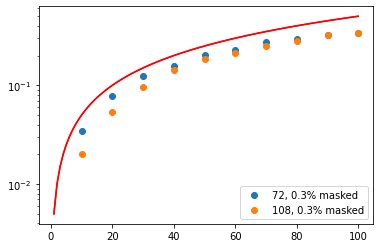

In [35]:
codes = [72, 108]
files = [f"results/q{c}/bp_osd.res" for c in codes]
p_mask = 0.3

for i, f in enumerate(files):

    df = pd.read_csv(f)
    df['p_error'] = 1 - df['p_log']
    df['p_std_dev'] = np.sqrt(df['p_error'] * df['p_log'] / df['no_test'])

    tmp_df = df[df["p_mask"] == p_mask]
    def fun(x, a):
        return 1 - (1 - a)**x

    popt, pcov = curve_fit(fun, tmp_df['t'], tmp_df['p_error'], maxfev=1000, p0=(0.001),
        sigma=tmp_df['p_std_dev'])

    # xx = np.linspace(1, 100, 100)
    # yy = fun(xx, *popt)
    # plt.plot(xx, yy, c='k')

    plt.plot(xx, [x*0.005 for x in xx], c='r')

    plt.scatter(tmp_df["t"], tmp_df["p_error"], label=f"{codes[i]}, {p_mask}% masked")
    plt.yscale('log')
    plt.legend(loc="lower right")